In [1]:
import sys
sys.path.append("../../")

import os
from PIL import Image
from pathlib import Path

from utils_cv.common.data import data_path
from utils_cv.detection.model import DetectionLearner, get_pretrained_fasterrcnn
from utils_cv.detection.dataset import DetectionDataset
from utils_cv.detection.plot import (
    display_bboxes,
    PlotSettings,
)

In [2]:
%load_ext blackcellmagic

# Ensure edits to libraries are loaded and plotting is shown in the notebook.
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
# model = get_pretrained_fasterrcnn(
#     num_classes=4 + 1, min_size=600, max_size=600 # use 600 for im size bc thats what the model was trained on
# )
# detector = DetectionLearner(model=model)

# detector.load(name="my_drink_detector", path=data_path()/"odFridgeObjects"/"models")

In [6]:
detector = DetectionLearner.from_model(name="my_drink_detector2", path=data_path()/"odFridgeObjects"/"models")

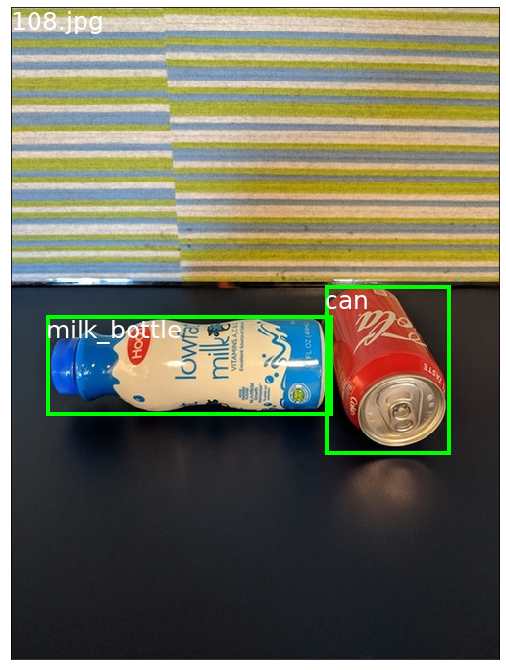

In [7]:
new_im_path = Path("/home/jiata/code/computervision/data/odFridgeObjects/images/108.jpg")

new_im = Image.open(new_im_path)
detections = detector.predict(new_im, threshold=0.5)

plot_settings = PlotSettings(rect_color=(0, 255, 0))
display_bboxes(
    detections,
    new_im_path,
    plot_settings=plot_settings,
)

---

In [3]:
# Azure resources
subscription_id = "989b90f7-da4f-41f9-84c9-44848802052d"
resource_group = "jiata-cv-aml"  
workspace_name = "jiata-cv-aml"  
workspace_region = "southcentralus" #Possible values eastus, eastus2, etc.

# Choose a size for our cluster and the maximum number of nodes
VM_SIZE = "STANDARD_NC6" #"STANDARD_NC6", STANDARD_NC6S_V3"
MAX_NODES = 10
KUBERNETES_CLUSTER_NAME = 'jiata-aks'

In [4]:
from utils_cv.common.azureml import get_or_create_workspace

ws = get_or_create_workspace(
    subscription_id, resource_group, workspace_name, workspace_region
)

# Print the workspace attributes
print(
    "Workspace name: " + ws.name,
    "Workspace region: " + ws.location,
    "Subscription id: " + ws.subscription_id,
    "Resource group: " + ws.resource_group,
    sep="\n",
)

Workspace name: jiata-cv-aml
Workspace region: southcentralus
Subscription id: 989b90f7-da4f-41f9-84c9-44848802052d
Resource group: jiata-cv-aml


Register the model

In [5]:
from azureml.core.model import Model

model = Model.register(
    model_path=os.path.join(
        data_path(), "odFridgeObjects", "models", "my_drink_detector.pt"
    ),
    model_name="drink_detector",
    tags={"Model": "object_detection"},
    description="Detect_drink_types",
    workspace=ws,
)

Registering model drink_detector


Scoring script:

In [10]:
scoring_script = "score.py"

In [ ]:
%%writefile $scoring_script
# Copyright (c) Microsoft. All rights reserved.
# Licensed under the MIT license.

import os
import json

from base64 import b64decode
from io import BytesIO

from azureml.core.model import Model
# from fastai.vision import load_learner, open_image
from utils_cv.detection.model import DetectionLearner, get_pretrained_fasterrcnn

def init():
    global model
    model_path = Model.get_model_path(model_name='drink_detector')
    # ! We cannot use the *model_name* variable here otherwise the execution on Azure will fail !
    
    model_dir_path, model_filename = os.path.split(model_path)
    model = load_learner(path=model_dir_path, fname=model_filename)


def run(raw_data):

    # Expects raw_data to be a list within a json file
    result = []    
    
    for im_string in json.loads(raw_data)['data']:
        im_bytes = b64decode(im_string)
        try:
            im = open_image(BytesIO(im_bytes))
            pred_class, pred_idx, outputs = model.predict(im)
            result.append({"label": str(pred_class), "probability": str(outputs[pred_idx].item())})
        except Exception as e:
            result.append({"label": str(e), "probability": ''})
    return result

First we create our Kubernetes cluster

In [12]:
from azureml.core.compute import AksCompute, ComputeTarget

prov_config = AksCompute.provisioning_configuration()

aks_target = ComputeTarget.create(
    workspace=ws, name=KUBERNETES_CLUSTER_NAME, provisioning_configuration=prov_config
)

# Wait for the create process to complete
aks_target.wait_for_completion(show_output=True)

Creating................................................................................................................................................................................................................................................
SucceededProvisioning operation finished, operation "Succeeded"


In [16]:
from azureml.core.compute import AksCompute, ComputeTarget

attach_config = AksCompute.attach_configuration(
    resource_group=ws.resource_group, cluster_name=KUBERNETES_CLUSTER_NAME
)
aks_target = ComputeTarget.attach(ws, "myaks", attach_config)

ComputeTargetException: ComputeTargetException:
	Message: Received bad response from Resource Provider:
Response Code: 400
Headers: {'Cache-Control': 'no-cache', 'Pragma': 'no-cache', 'Content-Length': '260', 'Content-Type': 'application/json', 'Expires': '-1', 'x-ms-correlation-request-id': '9310eaeb-0e77-4370-b607-ad7340b89831', 'x-ms-ratelimit-remaining-subscription-writes': '1196', 'Request-Context': 'appId=cid-v1:2d2e8e63-272e-4b3c-8598-4ee570a0e70d', 'x-ms-client-request-id': 'e73df957-8a77-4d36-a464-a737807439eb', 'x-ms-client-session-id': '', 'x-ms-request-id': '|85f570825411e74fa5214be1160952b4.98b4630a_1.707b1ab3_', 'Strict-Transport-Security': 'max-age=31536000; includeSubDomains', 'x-ms-routing-request-id': 'SOUTHCENTRALUS:20191014T183154Z:9310eaeb-0e77-4370-b607-ad7340b89831', 'X-Content-Type-Options': 'nosniff', 'Date': 'Mon, 14 Oct 2019 18:31:54 GMT'}
Content: b'{"code":"BadRequest","message":"The request is invalid","error":{"code":"BadRequest","statusCode":400,"message":"The request is invalid","details":[{"code":"BadRequestFormat","message":"Updating property provisioningState for compute is not supported yet."}]}}'
	InnerException None
	ErrorResponse 
{
    "error": {
        "message": "Received bad response from Resource Provider:\nResponse Code: 400\nHeaders: {'Cache-Control': 'no-cache', 'Pragma': 'no-cache', 'Content-Length': '260', 'Content-Type': 'application/json', 'Expires': '-1', 'x-ms-correlation-request-id': '9310eaeb-0e77-4370-b607-ad7340b89831', 'x-ms-ratelimit-remaining-subscription-writes': '1196', 'Request-Context': 'appId=cid-v1:2d2e8e63-272e-4b3c-8598-4ee570a0e70d', 'x-ms-client-request-id': 'e73df957-8a77-4d36-a464-a737807439eb', 'x-ms-client-session-id': '', 'x-ms-request-id': '|85f570825411e74fa5214be1160952b4.98b4630a_1.707b1ab3_', 'Strict-Transport-Security': 'max-age=31536000; includeSubDomains', 'x-ms-routing-request-id': 'SOUTHCENTRALUS:20191014T183154Z:9310eaeb-0e77-4370-b607-ad7340b89831', 'X-Content-Type-Options': 'nosniff', 'Date': 'Mon, 14 Oct 2019 18:31:54 GMT'}\nContent: b'{\"code\":\"BadRequest\",\"message\":\"The request is invalid\",\"error\":{\"code\":\"BadRequest\",\"statusCode\":400,\"message\":\"The request is invalid\",\"details\":[{\"code\":\"BadRequestFormat\",\"message\":\"Updating property provisioningState for compute is not supported yet.\"}]}}'"
    }
}